<a href="https://colab.research.google.com/github/Sebastien01/imnet_classification/blob/master/cnn_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping
import os
import random
import cv2
import numpy as np
from  matplotlib import pyplot as plt

# Get data (DataGenerator)

In [ ]:
train_path = '/content/drive/MyDrive/image_scene/data/seg_train/seg_train'
test_path = '/content/drive/MyDrive/image_scene/data/seg_test/seg_test'
pred_path = '/content/drive/MyDrive/image_scene/data/seg_pred/'

IMG_W,IMG_H = 160,160
BATCH_SIZE = 32

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255,validation_split=0.3)
test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_set = train_gen.flow_from_directory(train_path,
                                          target_size=(IMG_W,IMG_H),
                                          batch_size=BATCH_SIZE,
                                          class_mode='categorical',
                                          subset='training')

valid_set = train_gen.flow_from_directory(train_path,
                                          target_size=(IMG_W,IMG_H),
                                          batch_size=BATCH_SIZE,
                                          class_mode='categorical',
                                          subset='validation')

test_set = test_gen.flow_from_directory(test_path,
                                        target_size=(IMG_W,IMG_H),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

Found 9302 images belonging to 6 classes.
Found 3983 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Define models

In [ ]:
#Model 1 : number detection
def model_numbers():
  model = Sequential()
  model.add(layers.Conv2D(16, (3,3), padding='same', activation="relu",input_shape=(160,160,3)))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, (2,2), padding='same', activation="relu"))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(50, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(6, activation='softmax'))

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [ ]:
#Model 1 : number detection
def model_unet():
  model = Sequential()
  model.add(layers.Conv2D(32, (3,3), padding='same', activation="relu"))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64, (3,3), padding='same', activation="relu"))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(128, (3,3), padding='same', activation="relu"))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(256, (3,3), padding='same', activation="relu"))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(256, (2,2), padding='same', activation="relu"))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(128, (2,2), padding='same', activation="relu"))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64, (2,2), padding='same', activation="relu"))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, (2,2), padding='same', activation="relu"))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(50, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(6, activation='softmax'))

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
def model_unet_inception():
  model = Sequential()
  model.add(layers.Conv2D(32, (3,3), strides=2, padding="same",activation='relu',input_shape=(160,160,3)))
  for filters in [64, 128, 256]:
    model.add(layers.SeparableConv2D(filters,(3,3),padding='same',activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(3,3), strides=2, padding="same"))
  for filters in [256, 128, 64, 32]:
    model.add(layers.Conv2DTranspose(filters,(3,3),padding='same',activation='relu'))
    model.add(layers.UpSampling2D((2,2)))
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dense(6,activation='softmax'))
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
model = model_unet_inception()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
separable_conv2d (SeparableC (None, 80, 80, 64)        2400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 64)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 40, 40, 128)       8896      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 20, 20, 256)       34176     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 256)       0

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True,monitor='accuracy')
history = model.fit(train_set,batch_size=32,epochs=100,validation_data=valid_set,callbacks=[es])

Epoch 1/100
291/291 [==============================] - 3343s 11s/step - loss: 1.5192 - accuracy: 0.3507 - val_loss: 1.2596 - val_accuracy: 0.4567
Epoch 2/100
291/291 [==============================] - 32s 110ms/step - loss: 1.1218 - accuracy: 0.5570 - val_loss: 0.9554 - val_accuracy: 0.6242
Epoch 3/100
291/291 [==============================] - 32s 109ms/step - loss: 0.9405 - accuracy: 0.6312 - val_loss: 0.8585 - val_accuracy: 0.6731
Epoch 4/100
291/291 [==============================] - 32s 111ms/step - loss: 0.8347 - accuracy: 0.6762 - val_loss: 0.7520 - val_accuracy: 0.7113
Epoch 5/100
291/291 [==============================] - 32s 109ms/step - loss: 0.7657 - accuracy: 0.7054 - val_loss: 0.7066 - val_accuracy: 0.7233
Epoch 6/100
291/291 [==============================] - 31s 106ms/step - loss: 0.7332 - accuracy: 0.7212 - val_loss: 0.7133 - val_accuracy: 0.7203
Epoch 7/100
291/291 [==============================] - 32s 110ms/step - loss: 0.6821 - accuracy: 0.7446 - val_loss: 0.6832 -

In [ ]:
model2 = model_numbers()
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 80, 80, 32)        2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2560050   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)               

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True,monitor='accuracy')
history = model2.fit(train_set,batch_size=32,epochs=100,validation_data=valid_set,callbacks=[es])

Epoch 1/100
291/291 [==============================] - 32s 107ms/step - loss: 1.1678 - accuracy: 0.5524 - val_loss: 0.8649 - val_accuracy: 0.6834
Epoch 2/100
291/291 [==============================] - 29s 101ms/step - loss: 0.8636 - accuracy: 0.6744 - val_loss: 0.6941 - val_accuracy: 0.7514
Epoch 3/100
291/291 [==============================] - 32s 109ms/step - loss: 0.7075 - accuracy: 0.7425 - val_loss: 0.6626 - val_accuracy: 0.7632
Epoch 4/100
291/291 [==============================] - 31s 107ms/step - loss: 0.5939 - accuracy: 0.7866 - val_loss: 0.6369 - val_accuracy: 0.7688
Epoch 5/100
291/291 [==============================] - 29s 101ms/step - loss: 0.4877 - accuracy: 0.8234 - val_loss: 0.6242 - val_accuracy: 0.7778
Epoch 6/100
291/291 [==============================] - 31s 105ms/step - loss: 0.4145 - accuracy: 0.8507 - val_loss: 0.6312 - val_accuracy: 0.7821
Epoch 7/100
291/291 [==============================] - 29s 100ms/step - loss: 0.3466 - accuracy: 0.8733 - val_loss: 0.6820 -

# Evaluate and save model

In [ ]:
model.evaluate(test_set)

94/94 [==============================] - 969s 10s/step - loss: 0.9140 - accuracy: 0.8370


[0.9140424728393555, 0.8370000123977661]

In [ ]:
model2.evaluate(test_set)

94/94 [==============================] - 7s 70ms/step - loss: 1.6382 - accuracy: 0.7503


[1.6382337808609009, 0.750333309173584]

In [ ]:
save_model(model,'/content/drive/MyDrive/image_scene/model_unet')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/image_scene/model_unet/assets


**Première conclusion : 
Le premier modèle très basique (utilisé pour reconnaissance chiffres noir & blanc) VS Unet**

**Unet** : 83% accuracy pour 1M de paramètres à entrainer

**Model Basique** : 75% pour 2M de paramètres

L'approche du Unet semble plus performante, à savoir : détérminer et localiser des patternes sur l'image pour ensuite classifier l'image en fonction de la localisation de ces paternes 

L'approche du model basique ressemble davantage à un VGG16 simple : on réduit la résolution de l'image mais on augmente le nombre de couches.

On pourrait surement améliorer le modèle Unet avec du transfer Learning, ou avec du fine Tuning, notamment avec une régularisation L1 ou L2.

# Use model for predictions

In [ ]:
model = load_model('/content/drive/MyDrive/image_scene/model_unet')

In [17]:
pred_set = test_gen.flow_from_directory(pred_path,
                                        target_size=(IMG_W,IMG_H),
                                        batch_size=1,
                                        class_mode=None,
                                        color_mode='rgb',
                                        shuffle=False)

Found 7301 images belonging to 1 classes.


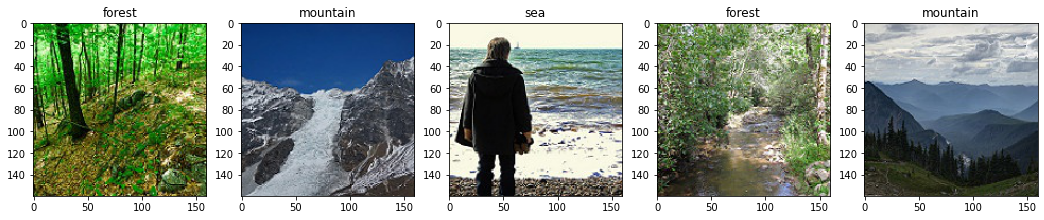

In [54]:
labels = {v:k for k,v in test_set.class_indices.items()}
fig,ax = plt.subplots(1,5, figsize = (18,5))
for i in range(5):
  img = pred_set.next()
  ax[i].imshow(img[0])
  prediction = labels[np.argmax(model.predict(img))]
  ax[i].set_title(prediction)